In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import collections
from pathlib import Path
from tqdm.auto import tqdm

import math
%pylab inline
%reload_ext autoreload
%autoreload 2


Populating the interactive namespace from numpy and matplotlib


/home/wassname/.pyenv/versions/3.7.2/envs/jup3.7.2/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
import logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger("smartmeters.ipynb")

In [3]:
import torch
from torch import nn
import torch.nn.functional as F

In [4]:
from src.models.model import LatentModel
from src.data.smart_meter import collate_fns, SmartMeterDataSet

In [5]:
# Params
device='cuda'
batch_size=32
num_workers=5
use_logy=False
num_context, num_extra_target = 24*2*3, 24*2
esp=1e-4

# Load kaggle smart meter data

In [6]:
csv_files = sorted(Path('data/smart-meters-in-london/halfhourly_dataset').glob('*.csv'))[:1]
df = pd.concat([pd.read_csv(f, parse_dates=[1], na_values=['Null']) for f in tqdm(csv_files)])
print(df.info())

df = df.groupby('tstp').mean()
df['tstp'] = df.index
df.index.name = ''
df.head(3)




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1222670 entries, 0 to 1222669
Data columns (total 3 columns):
LCLid             1222670 non-null object
tstp              1222670 non-null datetime64[ns]
energy(kWh/hh)    1222620 non-null float64
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 28.0+ MB
None


,energy(kWh/hh),tstp
,,
2011-12-03 09:00:00,0.149,2011-12-03 09:00:00
2011-12-03 09:30:00,0.154,2011-12-03 09:30:00
2011-12-03 10:00:00,0.768,2011-12-03 10:00:00


In [7]:
# Load weather data
df_weather = pd.read_csv('data/smart-meters-in-london/weather_hourly_darksky.csv', parse_dates=[3])

use_cols = ['visibility', 'windBearing', 'temperature', 'time', 'dewPoint',
       'pressure', 'apparentTemperature', 'windSpeed', 
       'humidity']
df_weather = df_weather[use_cols].set_index('time')

# Resample to match energy data    
df_weather = df_weather.resample('30T').ffill()

# Normalise
weather_norms=dict(mean={'visibility': 11.2,
 'windBearing': 195.7,
 'temperature': 10.5,
 'dewPoint': 6.5,
 'pressure': 1014.1,
 'apparentTemperature': 9.2,
 'windSpeed': 3.9,
 'humidity': 0.8},
std={'visibility': 3.1,
 'windBearing': 90.6,
 'temperature': 5.8,
 'dewPoint': 5.0,
 'pressure': 11.4,
 'apparentTemperature': 6.9,
 'windSpeed': 2.0,
 'humidity': 0.1})

for col in df_weather.columns:
    df_weather[col] -= weather_norms['mean'][col]
    df_weather[col] /= weather_norms['std'][col]

    
print(len(df))
df = pd.concat([df, df_weather], 1).dropna()
len(df)

39292


39225

In [8]:
# Also find bank holidays
df_hols = pd.read_csv('./data/smart-meters-in-london/uk_bank_holidays.csv', parse_dates=[0])
holidays = set(df_hols['Bank holidays'].dt.round('D'))

df['holiday'] = df.tstp.apply(lambda dt:dt.floor('D') in holidays).astype(int)

In [9]:
# Add time features
time = df.tstp
df["month"] = time.dt.month / 12.0
df['day'] = time.dt.day / 310.0
df['week'] = time.dt.week / 52.0
df['hour'] = time.dt.hour / 24.0
df['minute'] = time.dt.minute / 24.0
df['dayofweek'] = time.dt.dayofweek / 7.0

In [10]:
# Drop nan and 0's
df = df[df['energy(kWh/hh)']!=0]
df = df.dropna()

if use_logy:
    df['energy(kWh/hh)'] = np.log(df['energy(kWh/hh)']+eps)
df = df.sort_values('tstp')
df.describe()

,energy(kWh/hh),visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,holiday,month,day,week,hour,minute,dayofweek
count,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000
mean,0.449333,0.029285,0.018890,0.005533,0.009592,-0.010061,0.010214,0.013695,-0.202741,0.021976,0.529373,0.050786,0.495566,0.479369,0.624984,0.428291
std,0.218992,0.959951,1.002480,1.021497,1.030993,1.005238,1.030426,1.020799,1.401747,0.146606,0.306145,0.028288,0.307568,0.288379,0.625008,0.285822
min,0.023000,-3.525806,-2.160044,-2.782759,-3.296000,-3.364912,-2.620290,-1.930000,-5.700000,0.000000,0.083333,0.003226,0.019231,0.000000,0.000000,0.000000
25%,0.293000,-0.270968,-0.758278,-0.706897,-0.756000,-0.594737,-0.791304,-0.740000,-1.000000,0.000000,0.250000,0.025806,0.211538,0.250000,0.000000,0.142857
50%,0.436444,0.358065,0.257174,-0.089655,0.022000,0.034211,0.078261,-0.095000,0.100000,0.000000,0.500000,0.051613,0.480769,0.500000,0.000000,0.428571
75%,0.583932,0.606452,0.676600,0.712069,0.794000,0.680702,0.786957,0.605000,0.900000,0.000000,0.833333,0.074194,0.769231,0.750000,1.250000,0.714286
max,1.981000,1.577419,1.802428,3.775862,2.676000,2.563158,3.365217,5.450000,2.000000,1.000000,1.000000,0.100000,1.000000,0.958333,1.250000,0.857143


In [11]:
# split data
n_split = -int(len(df)*0.1)
df_train = df[:n_split]
df_test = df[n_split:]
len(df_train), len(df_test)

(35303, 3922)

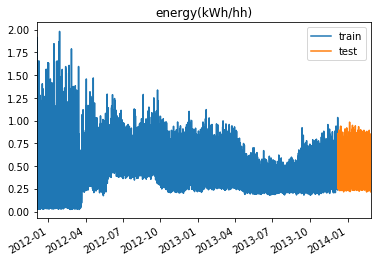

In [12]:
df_train['energy(kWh/hh)'].plot(label='train')
df_test['energy(kWh/hh)'].plot(label='test')
plt.title('energy(kWh/hh)')
plt.legend()

# Plot helpers

In [13]:
def plot_functions(target_x, target_y, context_x, context_y, pred_y, std, undo_log=use_logy, legend=False):
    """Plots the predicted mean and variance and the context points.
  
  Args: 
    target_x: An array of shape [B,num_targets,1] that contains the
        x values of the target points.
    target_y: An array of shape [B,num_targets,1] that contains the
        y values of the target points.
    context_x: An array of shape [B,num_contexts,1] that contains 
        the x values of the context points.
    context_y: An array of shape [B,num_contexts,1] that contains 
        the y values of the context points.
    pred_y: An array of shape [B,num_targets,1] that contains the
        predicted means of the y values at the target points in target_x.
    std: An array of shape [B,num_targets,1] that contains the
        predicted std dev of the y values at the target points in target_x.
      """
    if undo_log:
        target_y=np.exp(target_y)-eps
        context_y=np.exp(context_y)-eps
    # Plot everything 
    # Note: days is first feature in x, since we made sure of that in the dataloader)
    j=0
    
    plt.plot(target_x[0,:,j], target_y[0], 'k:', linewidth=2, label='true')
    plt.plot(context_x[0,:,j], context_y[0], 'ko', markersize=6, label='input data')
    ylims=plt.ylim()
    plt.plot(target_x[0,:,j], pred_y[0], 'b', linewidth=2, label='predicted')
    plt.fill_between(
          target_x[0, :, j],
          pred_y[0, :, 0] - std[0, :, 0],
          pred_y[0, :, 0] + std[0, :, 0],
          alpha=0.25,
          facecolor='blue',
          interpolate=True,
    label='uncertainty')

    # Make the plot pretty
    plt.grid('off')
    plt.ylim(*ylims)
    plt.xlabel('Days')
    plt.ylabel('Energy (kWh/hh)')
    plt.grid(b=None)
    if legend:
        plt.legend()
    ax = plt.gca()
    plt.show()

In [14]:
def plot_from_loader(loader, i=0, undo_log=use_logy, title='', plot=True, legend=False):
    data = loader.collate_fn([loader.dataset[i]])
    data = [d.to(device) for d in data]
    context_x, context_y, target_x, target_y = data

    model.eval()
    with torch.no_grad():
        y_pred, kl, loss_test, y_std = model(context_x, context_y, target_x, target_y)

        if plot:
            plt.title(title+f" loss={loss_test: 2.2g}")
            plot_functions(target_x.detach().cpu().numpy(),
                            target_y.detach().cpu().numpy(),
                            context_x.detach().cpu().numpy(),
                            context_y.detach().cpu().numpy(),
                            y_pred.detach().cpu().numpy(),
                            y_std.detach().cpu().numpy(), undo_log=undo_log, legend=legend)
    return loss_test

# Dataloaders

In [15]:
data_train = SmartMeterDataSet(df_train, num_context, num_extra_target)
data_test = SmartMeterDataSet(df_test, num_context, num_extra_target)

In [16]:
loader_train = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True, 
    collate_fn=collate_fns(num_context, num_extra_target, sample=True),
    num_workers=num_workers,
)

loader_test = torch.utils.data.DataLoader(data_test, batch_size=batch_size, shuffle=False, 
    collate_fn=collate_fns(num_context, num_extra_target, sample=False)
)

# Run

In [17]:
x, y, _, _ = next(iter(loader_train))
x.shape, y.shape

(torch.Size([32, 49, 16]), torch.Size([32, 49, 1]))

In [18]:
from torch import nn
import torch.nn.functional as F

class CausalConv1d(nn.Conv1d):
    """
    CausalConv1d which only pads on the left.

    See: https://github.com/iwasaki-kenta/keita/blob/master/layers/convolution.py#L40
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 dilation=1,
                 groups=1,
                 bias=True):
        super(CausalConv1d, self).__init__(
            in_channels,
            out_channels,
            kernel_size,
            stride=stride,
            padding=0,
            dilation=dilation,
            groups=groups,
            bias=bias)

        self.left_padding = dilation * (kernel_size - 1)

    def forward(self, input):
        x = F.pad(input.unsqueeze(2), (self.left_padding, 0, 0, 0)).squeeze(2)

        return super(CausalConv1d, self).forward(x)


In [47]:
def causalconv1d_relu_block(in_channels, out_channels, dropout=0, **kwargs):
    """This breaks docstrings, but saves code."""
    return nn.Sequential(
        CausalConv1d(in_channels, out_channels, **kwargs),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(out_channels),
        nn.Dropout(dropout),
    )

def relu_block(in_channels, out_channels, dropout=0, **kwargs):
    """This breaks docstrings, but saves code."""
    return nn.Sequential(
        nn.Linear(in_channels, out_channels, **kwargs),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(out_channels),
        nn.Dropout(dropout),
    )

class LSTM1d(nn.Module):
    """Simple LSTM model to predict seq of y given seq of x."""
    def __init__(self, channels, num_outputs, lstm_channels=32, dropout=0, lstm_layers=2, bidirectional=False):
        super().__init__()
        self.num_outputs = num_outputs
        self.pre_lstm = nn.Sequential(
            # 1x1 to reduce channels
            causalconv1d_relu_block(channels, lstm_channels, kernel_size=1, dropout=dropout)
        )
        self.lstm = nn.Sequential(
            nn.LSTM(
                lstm_channels,
                lstm_channels,
                num_layers=lstm_layers,
                bidirectional=bidirectional,
                batch_first=True,
#                 dropout=dropout,
            ),

        )
        
        # head to reduce features
        self.output = nn.Sequential(
            nn.LSTM(
                lstm_channels,
                num_outputs*2,
                num_layers=1,
                bidirectional=False,
                batch_first=True,
            )
        )
    
    def forward(self, context_x, context_y, target_x, target_y=None):
        x = target_x.permute([0, 2, 1])
        data = self.pre_lstm(x).permute([0, 2, 1])
        data = self.lstm(data)[0]#[:, -1]
        target_y_pred = self.output(data)[0]
        
        loc=target_y_pred[:, :, :self.num_outputs]
        log_scale=target_y_pred[:, :, self.num_outputs:] + math.log(0.1)
        scale = log_scale.exp()
        
        dist = torch.distributions.Normal(
            loc=loc, scale=scale)
        
        if target_y is not None:
            loss = - dist.log_prob(target_y).mean()
        else:
            loss = None
            
        y_pred = dist.rsample() if self.training else dist.loc
            
        return y_pred, torch.Tensor([0]), loss, dist.scale

In [48]:
from src.models.model import LatentModel
model = LSTM1d(
    x.shape[-1],
    y.shape[-1],
    dropout=0.5,
    lstm_channels=48,
    lstm_layers=4, ).cuda()

optim = torch.optim.AdamW(model.parameters(), lr=4e-5)

In [49]:
from torchsummaryX import summary
data = next(iter(loader_train))
data = [d.to(device) for d in data]
context_x, context_y, target_x, target_y = data
with torch.no_grad():
    model.eval()
    summary(model, context_x, context_y, target_x, target_y)
    dist, log_p, kl, loss = model(context_x, context_y, target_x, target_y)

                            Kernel Shape   Output Shape   Params Mult-Adds
Layer                                                                     
0_pre_lstm.0.CausalConv1d_0  [16, 48, 1]  [32, 48, 138]    816.0  105.984k
1_pre_lstm.0.ReLU_1                    -  [32, 48, 138]        -         -
2_pre_lstm.0.BatchNorm1d_2          [48]  [32, 48, 138]     96.0      48.0
3_pre_lstm.0.Dropout_3                 -  [32, 48, 138]        -         -
4_lstm.LSTM_0                          -  [32, 138, 48]  75.264k   73.728k
5_output.LSTM_0                        -   [32, 138, 2]    416.0     400.0
---------------------------------------------------------------------------
                       Totals
Total params          76.592k
Trainable params      76.592k
Non-trainable params      0.0
Mult-Adds             180.16k


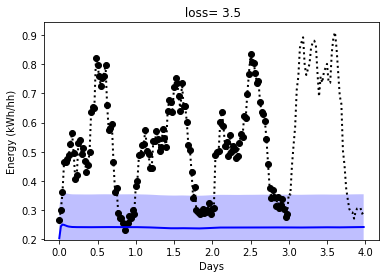

tensor(3.4764, device='cuda:0')

In [50]:
# Lets choose a challenging time to forecast
vis_i = 670 # 290 # 1600
plot_from_loader(loader_test, i=vis_i)

0, i=0, loss: 2.512, test: 3.444, grad_norm:  13, std:  0.11
0, i=100, loss: 1.162, test: 1.247, grad_norm:  7, std:  0.12


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe9b825c488>
Traceback (most recent call last):
  File "/home/wassname/.pyenv/versions/3.7.2/envs/jup3.7.2/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/wassname/.pyenv/versions/3.7.2/envs/jup3.7.2/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/home/wassname/.pyenv/versions/3.7.2/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe9b825c488>
Traceback (most recent call last):
  File "/home/wassname/.pyenv/versions/3.7.2/envs/jup3.7.2/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/wass

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe9b825c488>
AssertionError: can only join a child process
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe9b825c488>
  File "/home/wassname/.pyenv/versions/3.7.2/envs/jup3.7.2/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/home/wassname/.pyenv/versions/3.7.2/envs/jup3.7.2/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/wassname/.pyenv/versions/3.7.2/envs/jup3.7.2/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
  File "/home/wassname/.pyenv/versions/3.7.2/envs/jup3.7.2/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/home/wassname/.pyenv/versions/3.7.2/lib/

0, i=200, loss: 0.4997, test: 0.03035, grad_norm:  2.3, std:  0.13
0, i=300, loss: 0.08754, test: -0.2596, grad_norm:  1.2, std:  0.15
0, i=400, loss: -0.03076, test: -0.2314, grad_norm:  0.51, std:  0.2
0, i=500, loss: -0.1359, test: -0.1894, grad_norm:  0.19, std:  0.21
0, i=600, loss: -0.1143, test: -0.2016, grad_norm:  0.39, std:  0.21
0, i=700, loss: 0.1688, test: -0.2074, grad_norm:  0.72, std:  0.18
0, i=800, loss: -0.1642, test: -0.2349, grad_norm:  0.32, std:  0.21
0, i=900, loss: -0.04615, test: -0.2409, grad_norm:  0.66, std:  0.21
0, i=1000, loss: -0.1822, test: -0.2511, grad_norm:  0.4, std:  0.21


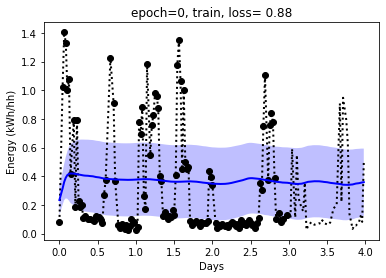

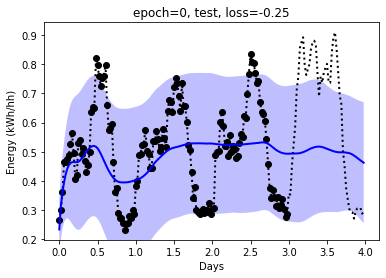

epoch: 0, loss: -0.2158, loss_test:-0.2505, kl= 0, grad_norm:  0.69


1, i=0, loss: -0.1671, test: -0.2527, grad_norm:  0.43, std:  0.2


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe9b825c488>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe9b825c488>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe9b825c488>
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/wassname/.pyenv/versions/3.7.2/envs/jup3.7.2/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
  File "/home/wassname/.pyenv/versions/3.7.2/envs/jup3.7.2/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
  File "/home/wassname/.pyenv/versions/3.7.2/envs/jup3.7.2/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
    self._shutdown_workers()
  File "/home/wassname/.pyenv/versions/3.7.2/envs/jup3.7.2/lib/python3.7/site-packages/torch/utils/data/dataloader.

    self._shutdown_workers()
  File "/home/wassname/.pyenv/versions/3.7.2/envs/jup3.7.2/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
Traceback (most recent call last):
  File "/home/wassname/.pyenv/versions/3.7.2/envs/jup3.7.2/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/home/wassname/.pyenv/versions/3.7.2/envs/jup3.7.2/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
  File "/home/wassname/.pyenv/versions/3.7.2/lib/python3.7/multiprocessing/process.py", line 138, in join
    self._shutdown_workers()
  File "/home/wassname/.pyenv/versions/3.7.2/envs/jup3.7.2/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only join a child process'
    w.join()
AssertionError: can only join a child process
    w.join()
  File "/home/wassname/.pyenv/versions/3.7.2/l

1, i=100, loss: -0.04737, test: -0.242, grad_norm:  0.84, std:  0.2
1, i=200, loss: 0.185, test: -0.2388, grad_norm:  0.82, std:  0.2
1, i=300, loss: 0.02419, test: -0.2363, grad_norm:  0.5, std:  0.2
1, i=400, loss: -0.1234, test: -0.2484, grad_norm:  1.2, std:  0.2
1, i=500, loss: -0.05025, test: -0.2229, grad_norm:  1.1, std:  0.19
1, i=600, loss: -0.2202, test: -0.2511, grad_norm:  0.48, std:  0.2
1, i=700, loss: -0.1882, test: -0.219, grad_norm:  0.58, std:  0.2
1, i=800, loss: -0.2114, test: -0.1983, grad_norm:  0.7, std:  0.2
1, i=900, loss: -0.1769, test: -0.2343, grad_norm:  0.68, std:  0.2
1, i=1000, loss: -0.08422, test: -0.2389, grad_norm:  0.43, std:  0.21


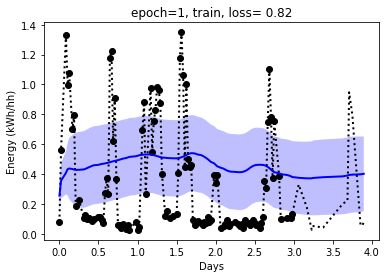

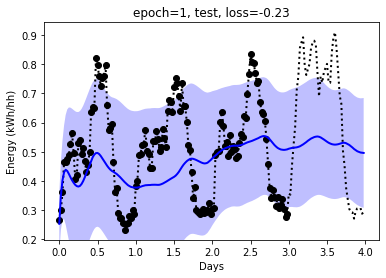

epoch: 1, loss: -0.3486, loss_test:-0.2284, kl= 0, grad_norm:  0.61


2, i=0, loss: -0.1289, test: -0.2309, grad_norm:  1.1, std:  0.2
2, i=100, loss: -0.2667, test: -0.1838, grad_norm:  1.1, std:  0.2
2, i=200, loss: -0.1397, test: -0.1898, grad_norm:  0.43, std:  0.19
2, i=300, loss: -0.1961, test: -0.1314, grad_norm:  1, std:  0.19
2, i=400, loss: -0.1683, test: -0.06374, grad_norm:  0.84, std:  0.2
2, i=500, loss: -0.1697, test: -0.08574, grad_norm:  0.58, std:  0.19
2, i=600, loss: -0.1995, test: -0.0958, grad_norm:  0.75, std:  0.2
2, i=700, loss: -0.06842, test: -0.08077, grad_norm:  0.64, std:  0.2
2, i=800, loss: -0.2636, test: -0.09184, grad_norm:  0.6, std:  0.19
2, i=900, loss: -0.05513, test: -0.09258, grad_norm:  1.6, std:  0.19
2, i=1000, loss: -0.174, test: -0.05958, grad_norm:  1, std:  0.19


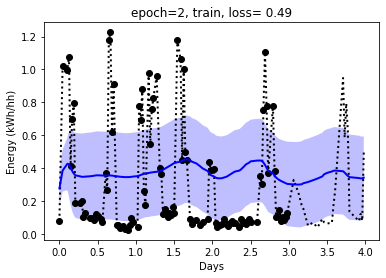

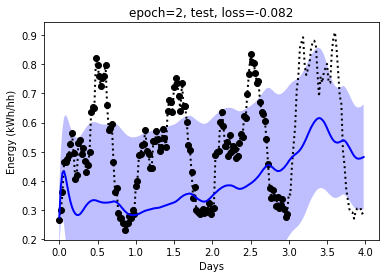

epoch: 2, loss: -0.2315, loss_test:-0.08215, kl= 0, grad_norm:  2.1


3, i=0, loss: -0.2351, test: -0.08066, grad_norm:  0.47, std:  0.2
3, i=100, loss: -0.1979, test: -0.1157, grad_norm:  1.4, std:  0.19
3, i=200, loss: -0.1926, test: -0.111, grad_norm:  0.99, std:  0.19
3, i=300, loss: -0.1948, test: -0.1154, grad_norm:  0.79, std:  0.19
3, i=400, loss: -0.1939, test: -0.1328, grad_norm:  2.9, std:  0.19
3, i=500, loss: -0.1229, test: -0.1168, grad_norm:  1.4, std:  0.2
3, i=600, loss: -0.1722, test: -0.1017, grad_norm:  0.9, std:  0.19
3, i=700, loss: -0.1765, test: -0.09779, grad_norm:  1.1, std:  0.2
3, i=800, loss: -0.2946, test: -0.1389, grad_norm:  2.1, std:  0.19
3, i=900, loss: -0.2855, test: -0.1142, grad_norm:  2.8, std:  0.19
3, i=1000, loss: -0.2732, test: -0.1126, grad_norm:  2, std:  0.19


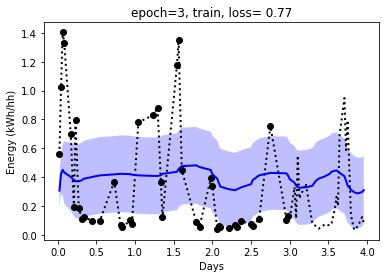

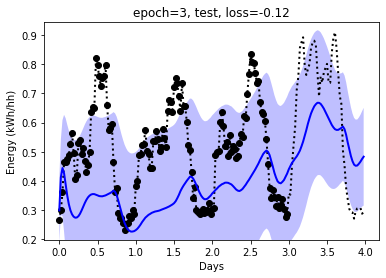

epoch: 3, loss: -0.4558, loss_test:-0.12, kl= 0, grad_norm:  1.7


4, i=0, loss: -0.281, test: -0.1162, grad_norm:  0.93, std:  0.18
4, i=100, loss: -0.1365, test: -0.06718, grad_norm:  2.2, std:  0.19
4, i=200, loss: -0.07399, test: -0.1117, grad_norm:  2.5, std:  0.19
4, i=300, loss: -0.2595, test: -0.1394, grad_norm:  4.2, std:  0.19
4, i=400, loss: -0.1079, test: -0.1227, grad_norm:  1.3, std:  0.19
4, i=500, loss: -0.1901, test: -0.103, grad_norm:  0.91, std:  0.19
4, i=600, loss: -0.2818, test: -0.1102, grad_norm:  0.74, std:  0.18
4, i=700, loss: -0.329, test: -0.07443, grad_norm:  1.4, std:  0.18
4, i=800, loss: -0.3443, test: -0.158, grad_norm:  0.95, std:  0.18
4, i=900, loss: -0.2849, test: -0.1513, grad_norm:  2.6, std:  0.18
4, i=1000, loss: -0.2657, test: -0.1545, grad_norm:  1, std:  0.19


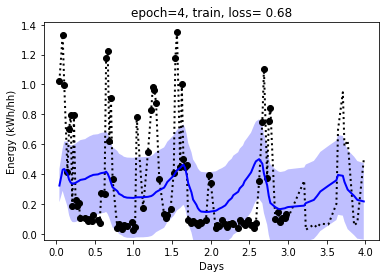

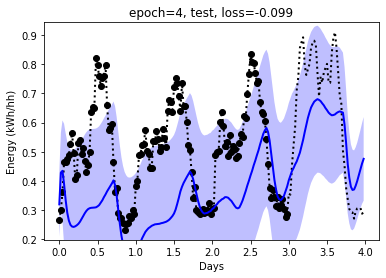

epoch: 4, loss: -0.3744, loss_test:-0.09862, kl= 0, grad_norm:  2.7


5, i=0, loss: -0.04486, test: -0.1044, grad_norm:  2.8, std:  0.18
5, i=100, loss: -0.268, test: -0.1185, grad_norm:  0.91, std:  0.18
5, i=200, loss: -0.3562, test: -0.1258, grad_norm:  2.5, std:  0.18
5, i=300, loss: -0.3235, test: -0.156, grad_norm:  1.1, std:  0.18
5, i=400, loss: -0.3867, test: -0.1699, grad_norm:  1.7, std:  0.17
5, i=500, loss: -0.3947, test: -0.1376, grad_norm:  2.9, std:  0.17
5, i=600, loss: -0.369, test: -0.1076, grad_norm:  1.6, std:  0.17
5, i=700, loss: -0.2843, test: -0.01721, grad_norm:  1.4, std:  0.18
5, i=800, loss: -0.4234, test: -0.1285, grad_norm:  2.7, std:  0.17
5, i=900, loss: -0.3659, test: -0.1288, grad_norm:  1.7, std:  0.18
5, i=1000, loss: -0.2383, test: -0.1455, grad_norm:  3.1, std:  0.18


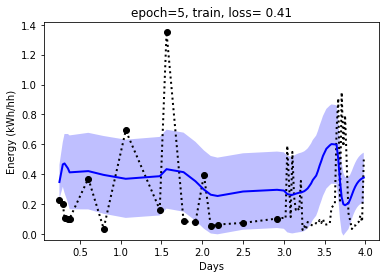

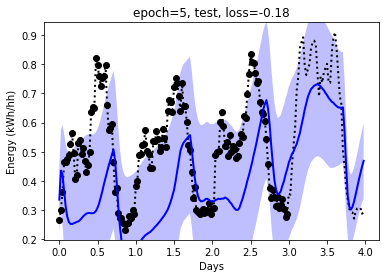

epoch: 5, loss: -0.3265, loss_test:-0.1753, kl= 0, grad_norm:  2.4


6, i=0, loss: -0.285, test: -0.1707, grad_norm:  2.4, std:  0.17
6, i=100, loss: -0.5225, test: -0.1227, grad_norm:  3, std:  0.17
6, i=200, loss: -0.5287, test: -0.1455, grad_norm:  1.2, std:  0.17
6, i=300, loss: -0.4307, test: -0.09796, grad_norm:  1.7, std:  0.17
6, i=400, loss: -0.2777, test: -0.1139, grad_norm:  2.7, std:  0.18
6, i=500, loss: -0.4389, test: -0.08937, grad_norm:  4.1, std:  0.17
6, i=600, loss: -0.4798, test: -0.08293, grad_norm:  1.8, std:  0.17
6, i=700, loss: -0.413, test: -0.1295, grad_norm:  2.1, std:  0.17
6, i=800, loss: -0.4292, test: -0.1082, grad_norm:  1.7, std:  0.17
6, i=900, loss: -0.4278, test: -0.1228, grad_norm:  1.5, std:  0.17
6, i=1000, loss: -0.4491, test: -0.07286, grad_norm:  1.8, std:  0.17


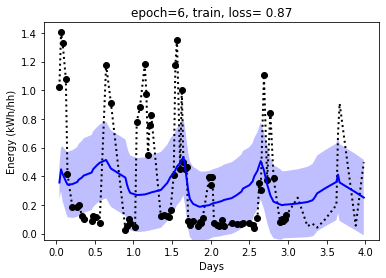

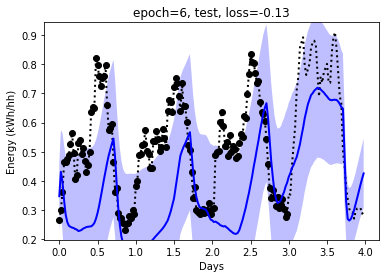

epoch: 6, loss: -0.2998, loss_test:-0.1279, kl= 0, grad_norm:  5.5


7, i=0, loss: -0.5004, test: -0.1016, grad_norm:  1.5, std:  0.16
7, i=100, loss: -0.3287, test: -0.07328, grad_norm:  2.9, std:  0.17
7, i=200, loss: -0.5121, test: -0.1546, grad_norm:  3.9, std:  0.16
7, i=300, loss: -0.2512, test: -0.07818, grad_norm:  1.6, std:  0.17
7, i=400, loss: -0.5178, test: -0.08866, grad_norm:  2.2, std:  0.16
7, i=500, loss: -0.4795, test: -0.07155, grad_norm:  1.8, std:  0.16
7, i=600, loss: -0.4924, test: -0.04968, grad_norm:  2.5, std:  0.16
7, i=700, loss: -0.3155, test: -0.04837, grad_norm:  1.3, std:  0.17
7, i=800, loss: -0.4338, test: -0.1572, grad_norm:  1.6, std:  0.17
7, i=900, loss: -0.455, test: -0.07148, grad_norm:  1.4, std:  0.16
7, i=1000, loss: -0.2955, test: -0.04372, grad_norm:  1.7, std:  0.17


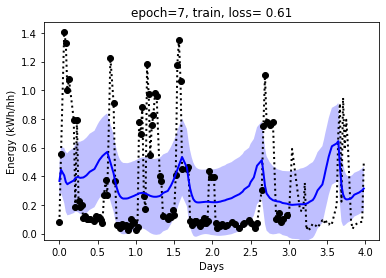

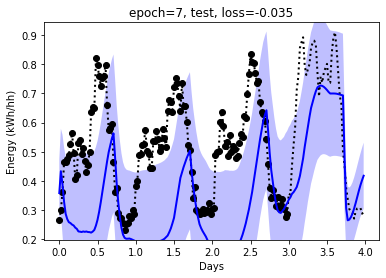

epoch: 7, loss: -0.5457, loss_test:-0.03454, kl= 0, grad_norm:  5.5


8, i=0, loss: -0.6098, test: -0.02357, grad_norm:  4.5, std:  0.15
8, i=100, loss: -0.59, test: -0.01132, grad_norm:  2.2, std:  0.16
8, i=200, loss: -0.5033, test: -0.07797, grad_norm:  0.93, std:  0.16
8, i=300, loss: -0.4626, test: -0.02257, grad_norm:  2.3, std:  0.16
8, i=400, loss: -0.4031, test: -0.03395, grad_norm:  5.5, std:  0.16
8, i=500, loss: -0.4761, test: -0.01652, grad_norm:  2.2, std:  0.16
8, i=600, loss: -0.2808, test: -0.03653, grad_norm:  5.4, std:  0.16
8, i=700, loss: -0.3288, test: -0.07622, grad_norm:  2.7, std:  0.17
8, i=800, loss: -0.527, test: -0.07475, grad_norm:  4.4, std:  0.16
8, i=900, loss: -0.3643, test: -0.04047, grad_norm:  2.4, std:  0.16
8, i=1000, loss: -0.5941, test: -0.04917, grad_norm:  3.4, std:  0.15


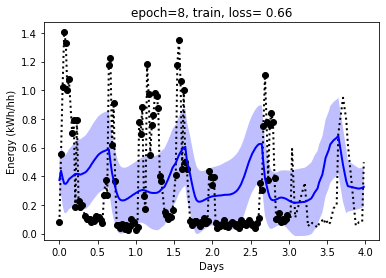

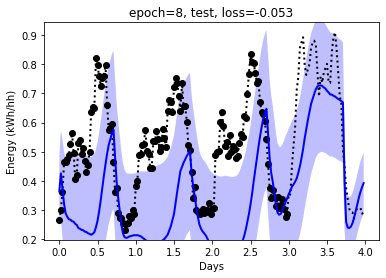

epoch: 8, loss: -0.3723, loss_test:-0.05328, kl= 0, grad_norm:  17


9, i=0, loss: -0.311, test: -0.05897, grad_norm:  9.2, std:  0.16
9, i=100, loss: -0.4723, test: 0.009649, grad_norm:  3.2, std:  0.16
9, i=200, loss: -0.2926, test: -0.08051, grad_norm:  2.4, std:  0.17
9, i=300, loss: -0.3589, test: -0.0112, grad_norm:  2, std:  0.17
9, i=400, loss: -0.4199, test: -0.09421, grad_norm:  1.9, std:  0.16
9, i=500, loss: -0.3465, test: -0.04239, grad_norm:  2.6, std:  0.16
9, i=600, loss: -0.4653, test: 0.002447, grad_norm:  3.3, std:  0.16
9, i=700, loss: -0.5743, test: -0.05982, grad_norm:  2.9, std:  0.16
9, i=800, loss: -0.5928, test: -0.08675, grad_norm:  1.1, std:  0.16
9, i=900, loss: -0.5328, test: -0.0443, grad_norm:  1.7, std:  0.15
9, i=1000, loss: -0.3412, test: -0.06714, grad_norm:  5.3, std:  0.16


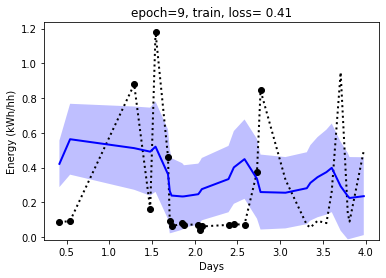

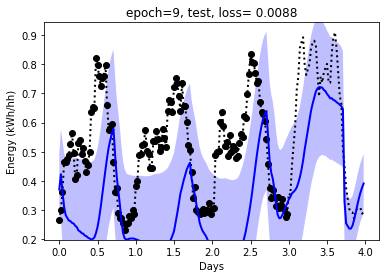

epoch: 9, loss: -0.6716, loss_test:0.008774, kl= 0, grad_norm:  4.9


10, i=0, loss: -0.5015, test: 0.02258, grad_norm:  1, std:  0.16
10, i=100, loss: -0.4617, test: -0.02985, grad_norm:  1.7, std:  0.16
10, i=200, loss: -0.5887, test: -0.05728, grad_norm:  2.7, std:  0.15
10, i=300, loss: -0.5824, test: 0.0004213, grad_norm:  3.8, std:  0.15
10, i=400, loss: -0.4338, test: -0.04154, grad_norm:  8.7, std:  0.16
10, i=500, loss: -0.5282, test: 0.04193, grad_norm:  3.9, std:  0.15
10, i=600, loss: -0.4712, test: 0.04312, grad_norm:  2.1, std:  0.15
10, i=700, loss: -0.5578, test: 0.008726, grad_norm:  1.6, std:  0.15
10, i=800, loss: -0.5545, test: -0.0418, grad_norm:  2.5, std:  0.15
10, i=900, loss: -0.4016, test: -0.01361, grad_norm:  1.6, std:  0.17
10, i=1000, loss: -0.5934, test: 0.000752, grad_norm:  2.7, std:  0.16


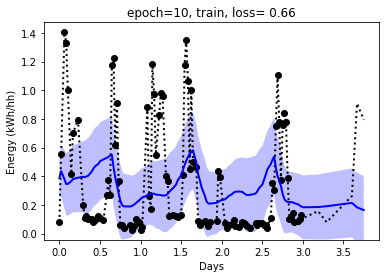

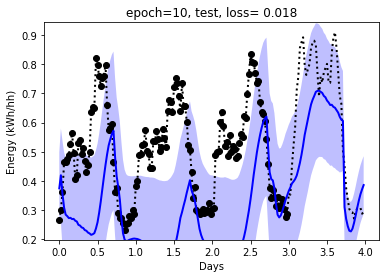

epoch: 10, loss: 0.005879, loss_test:0.018, kl= 0, grad_norm:  22


11, i=0, loss: -0.6392, test: 0.02241, grad_norm:  2.3, std:  0.15
11, i=100, loss: -0.5133, test: -0.005063, grad_norm:  2.2, std:  0.16
11, i=200, loss: -0.4232, test: 0.006186, grad_norm:  1.7, std:  0.16
11, i=300, loss: -0.6244, test: 0.02705, grad_norm:  1.7, std:  0.15
11, i=400, loss: -0.2311, test: -0.01163, grad_norm:  2.5, std:  0.17
11, i=500, loss: -0.3333, test: 0.127, grad_norm:  1.5, std:  0.17
11, i=600, loss: -0.5186, test: 0.05752, grad_norm:  2.9, std:  0.15
11, i=700, loss: -0.1991, test: -0.02002, grad_norm:  4, std:  0.16
11, i=800, loss: -0.5176, test: 0.02944, grad_norm:  7.7, std:  0.15
11, i=900, loss: -0.4933, test: -0.003034, grad_norm:  2.3, std:  0.16
11, i=1000, loss: -0.5376, test: -0.00223, grad_norm:  1.9, std:  0.15


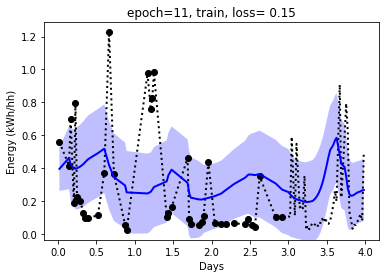

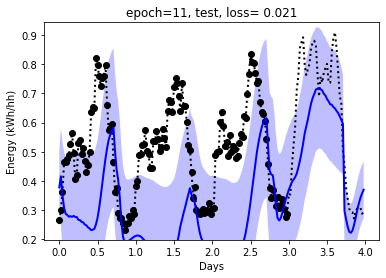

epoch: 11, loss: -0.4701, loss_test:0.02135, kl= 0, grad_norm:  15


12, i=0, loss: -0.4853, test: 0.02831, grad_norm:  6.6, std:  0.15
12, i=100, loss: -0.6593, test: 0.02101, grad_norm:  2.9, std:  0.14
12, i=200, loss: -0.6356, test: 0.02154, grad_norm:  3.5, std:  0.14
12, i=300, loss: -0.6086, test: 0.07005, grad_norm:  3.3, std:  0.15
12, i=400, loss: -0.6349, test: 0.0466, grad_norm:  2.1, std:  0.14
12, i=500, loss: -0.5731, test: -0.007837, grad_norm:  2.1, std:  0.15
12, i=600, loss: -0.461, test: 0.01952, grad_norm:  2.2, std:  0.16
12, i=700, loss: -0.6727, test: 0.01618, grad_norm:  1.8, std:  0.14
12, i=800, loss: -0.6147, test: 0.01888, grad_norm:  1.4, std:  0.14
12, i=900, loss: -0.5506, test: 0.0461, grad_norm:  4, std:  0.15
12, i=1000, loss: -0.5296, test: 0.002571, grad_norm:  4.8, std:  0.15


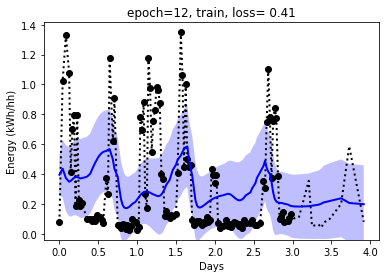

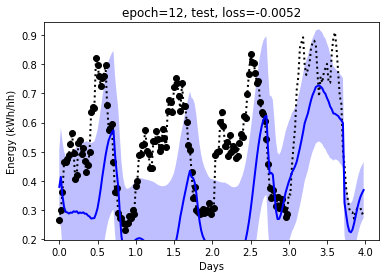

epoch: 12, loss: -0.7176, loss_test:-0.005227, kl= 0, grad_norm:  5.2


13, i=0, loss: -0.5345, test: -0.008259, grad_norm:  1.7, std:  0.15
13, i=100, loss: -0.4483, test: -0.01454, grad_norm:  6, std:  0.15
13, i=200, loss: -0.5063, test: 0.01337, grad_norm:  3.6, std:  0.16
13, i=300, loss: -0.4373, test: 0.001986, grad_norm:  2.1, std:  0.16
13, i=400, loss: -0.783, test: 0.0694, grad_norm:  3.1, std:  0.14
13, i=500, loss: -0.5044, test: 0.04909, grad_norm:  3.2, std:  0.15
13, i=600, loss: -0.5749, test: 0.04118, grad_norm:  8.3, std:  0.14
13, i=700, loss: -0.5188, test: 0.0831, grad_norm:  3.7, std:  0.15
13, i=800, loss: -0.5133, test: 0.05046, grad_norm:  2.9, std:  0.15
13, i=900, loss: -0.4984, test: 0.04579, grad_norm:  4, std:  0.15
13, i=1000, loss: -0.6445, test: 0.1208, grad_norm:  4.1, std:  0.15


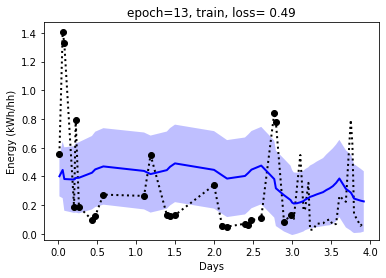

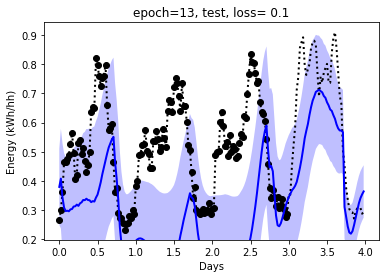

epoch: 13, loss: -0.4703, loss_test:0.1033, kl= 0, grad_norm:  7.3


14, i=0, loss: -0.6043, test: 0.1044, grad_norm:  2.3, std:  0.14
14, i=100, loss: -0.4726, test: 0.1019, grad_norm:  3.4, std:  0.16
14, i=200, loss: -0.5579, test: 0.04161, grad_norm:  4.1, std:  0.15
14, i=300, loss: -0.7105, test: 0.09444, grad_norm:  3.9, std:  0.14
14, i=400, loss: -0.5064, test: 0.1055, grad_norm:  3.3, std:  0.15
14, i=500, loss: -0.5473, test: 0.09176, grad_norm:  1.4, std:  0.15
14, i=600, loss: -0.4338, test: 0.0579, grad_norm:  4.2, std:  0.16
14, i=700, loss: -0.7145, test: 0.04978, grad_norm:  1.9, std:  0.13
14, i=800, loss: -0.6221, test: 0.04776, grad_norm:  2.3, std:  0.14
14, i=900, loss: -0.4077, test: 0.1223, grad_norm:  8.4, std:  0.15
14, i=1000, loss: -0.6056, test: 0.03496, grad_norm:  2.1, std:  0.15


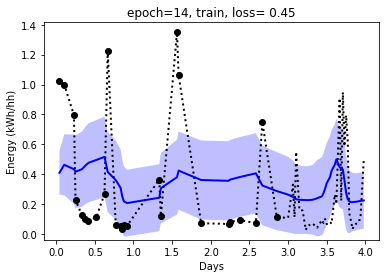

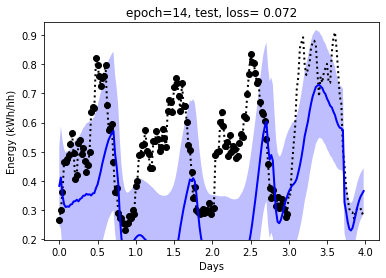

epoch: 14, loss: -0.3516, loss_test:0.07163, kl= 0, grad_norm:  5.4


15, i=0, loss: -0.6828, test: 0.07096, grad_norm:  2.2, std:  0.14
15, i=100, loss: -0.3338, test: 0.1146, grad_norm:  3.5, std:  0.16
15, i=200, loss: -0.5944, test: 0.1202, grad_norm:  3.1, std:  0.15
15, i=300, loss: -0.5426, test: 0.1624, grad_norm:  3.3, std:  0.14
15, i=400, loss: -0.4154, test: 0.08054, grad_norm:  2.3, std:  0.16
15, i=500, loss: -0.4716, test: 0.1442, grad_norm:  5.6, std:  0.15
15, i=600, loss: -0.3822, test: -0.005016, grad_norm:  1.6, std:  0.17
15, i=700, loss: -0.6051, test: 0.1122, grad_norm:  2.7, std:  0.15
15, i=800, loss: -0.738, test: 0.04132, grad_norm:  1.3, std:  0.13
15, i=900, loss: -0.6839, test: 0.1402, grad_norm:  3.3, std:  0.14
15, i=1000, loss: -0.5622, test: 0.05073, grad_norm:  3.4, std:  0.15


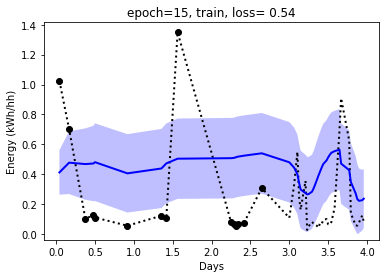

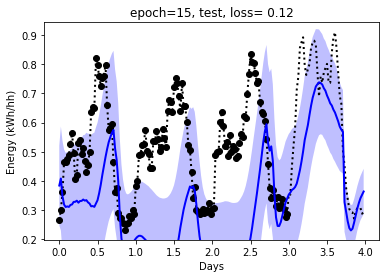

epoch: 15, loss: -0.0221, loss_test:0.1247, kl= 0, grad_norm:  43


16, i=0, loss: -0.6994, test: 0.127, grad_norm:  1.9, std:  0.14
16, i=100, loss: -0.5965, test: 0.1411, grad_norm:  3.2, std:  0.15
16, i=200, loss: -0.6966, test: 0.05825, grad_norm:  2, std:  0.13
16, i=300, loss: -0.5893, test: 0.09048, grad_norm:  3, std:  0.14
16, i=400, loss: -0.6602, test: 0.1292, grad_norm:  2.2, std:  0.14
16, i=500, loss: -0.632, test: 0.1966, grad_norm:  2.2, std:  0.14
16, i=600, loss: -0.8699, test: 0.1006, grad_norm:  2.1, std:  0.12
16, i=700, loss: -0.4652, test: 0.1029, grad_norm:  3.6, std:  0.16
16, i=800, loss: -0.3451, test: 0.2136, grad_norm:  16, std:  0.16
16, i=900, loss: -0.643, test: 0.1587, grad_norm:  2.2, std:  0.14
16, i=1000, loss: -0.6533, test: 0.2158, grad_norm:  2.3, std:  0.14


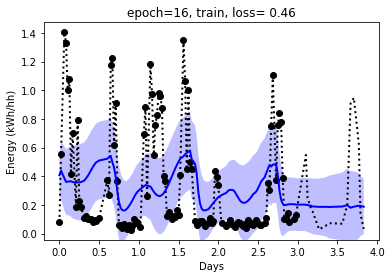

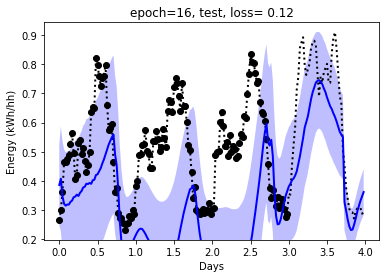

epoch: 16, loss: -0.8245, loss_test:0.1233, kl= 0, grad_norm:  2.9


17, i=0, loss: -0.7878, test: 0.1285, grad_norm:  2.3, std:  0.13
17, i=100, loss: -0.7158, test: 0.1822, grad_norm:  1.9, std:  0.14
17, i=200, loss: -0.7044, test: 0.1672, grad_norm:  4.3, std:  0.13
17, i=300, loss: -0.6373, test: 0.243, grad_norm:  3.4, std:  0.14
17, i=400, loss: -0.6291, test: 0.2009, grad_norm:  3.3, std:  0.14
17, i=500, loss: -0.7431, test: 0.2788, grad_norm:  3.1, std:  0.13
17, i=600, loss: -0.3943, test: 0.1659, grad_norm:  3.7, std:  0.16
17, i=700, loss: -0.3142, test: 0.1922, grad_norm:  11, std:  0.16
17, i=800, loss: -0.7323, test: 0.1885, grad_norm:  1.9, std:  0.13
17, i=900, loss: -0.5145, test: 0.2314, grad_norm:  6, std:  0.14
17, i=1000, loss: -0.5181, test: 0.3513, grad_norm:  2.1, std:  0.16


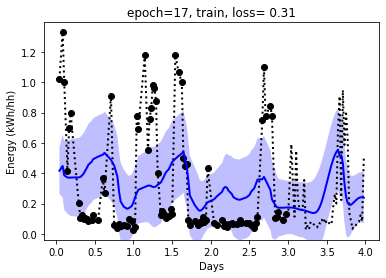

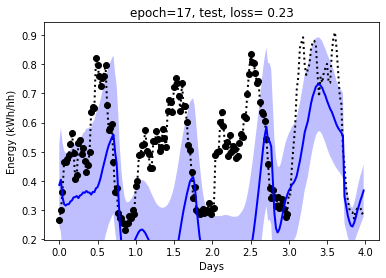

epoch: 17, loss: -0.9703, loss_test:0.2313, kl= 0, grad_norm:  6.5


18, i=0, loss: -0.6972, test: 0.2397, grad_norm:  7.9, std:  0.13
18, i=100, loss: -0.6043, test: 0.2001, grad_norm:  2.7, std:  0.15
18, i=200, loss: -0.8958, test: 0.2809, grad_norm:  1.8, std:  0.12
18, i=300, loss: -0.5589, test: 0.2634, grad_norm:  9.4, std:  0.14
18, i=400, loss: -0.8218, test: 0.3204, grad_norm:  2.4, std:  0.12
18, i=500, loss: -0.7302, test: 0.2642, grad_norm:  1.5, std:  0.13
18, i=600, loss: -0.4307, test: 0.2628, grad_norm:  2.8, std:  0.16
18, i=700, loss: -0.713, test: 0.3495, grad_norm:  2.1, std:  0.14
18, i=800, loss: -0.6672, test: 0.3272, grad_norm:  3.1, std:  0.14
18, i=900, loss: -0.7419, test: 0.315, grad_norm:  1.6, std:  0.13
18, i=1000, loss: -0.8068, test: 0.4204, grad_norm:  3.2, std:  0.13


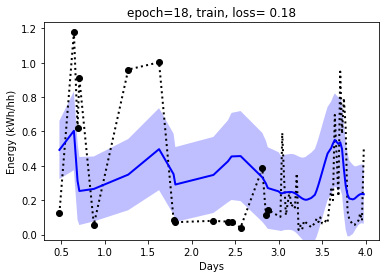

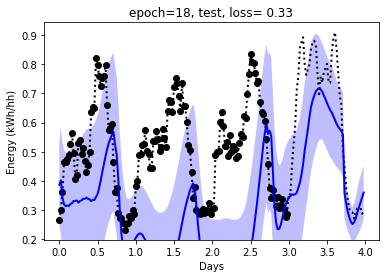

epoch: 18, loss: -0.3011, loss_test:0.3291, kl= 0, grad_norm:  7.5


19, i=0, loss: -0.7868, test: 0.3151, grad_norm:  1.9, std:  0.14
19, i=100, loss: -0.5932, test: 0.3622, grad_norm:  1.9, std:  0.14
19, i=200, loss: -0.667, test: 0.3848, grad_norm:  5.3, std:  0.14
19, i=300, loss: -0.7443, test: 0.3106, grad_norm:  1.4, std:  0.12
19, i=400, loss: -0.4649, test: 0.3379, grad_norm:  2.3, std:  0.16
19, i=500, loss: -0.7432, test: 0.4284, grad_norm:  2, std:  0.13
19, i=600, loss: -0.5411, test: 0.3948, grad_norm:  1.6, std:  0.15
19, i=700, loss: -0.6555, test: 0.3547, grad_norm:  3.6, std:  0.14
19, i=800, loss: -0.839, test: 0.3172, grad_norm:  3.4, std:  0.12
19, i=900, loss: -0.5635, test: 0.2794, grad_norm:  2.8, std:  0.15
19, i=1000, loss: -0.7077, test: 0.4126, grad_norm:  2.6, std:  0.13


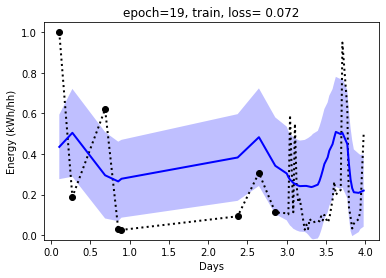

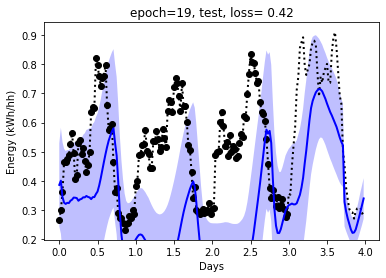

epoch: 19, loss: -0.9157, loss_test:0.4205, kl= 0, grad_norm:  4.8


In [51]:
epochs = 20
grad_clip = 10
history = []
for epoch in tqdm(range(epochs), unit='epoch'):

    pbar = tqdm(loader_train, unit='batch')
    for i, data in enumerate(pbar):
        model.train()
        assert all(torch.isfinite(d).all() for d in data)
        data = [d.to(device) for d in data]
        context_x, context_y, target_x, target_y = data

        optim.zero_grad()
        y_pred, kl, loss, y_std = model(context_x, context_y, target_x, target_y)

        # These attentive NP models work great when you need uncertainty, but still seem a bit unstable. 
        # Sometimes they produce nans, especically if the data is not fully normalized. 
        assert torch.isfinite(y_pred.sum())
        if not torch.isfinite(loss):
            logger.error("loss is not finite")
            continue
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        if not np.isfinite(grad_norm):
            logger.error("grad_norm is not finite")
            continue
        optim.step()

        if i%100==0:
            model.eval()
            test_loss = plot_from_loader(loader_test, i=vis_i, plot=False)
            pbar.set_description(f"{epoch}, loss: {loss.item():4.4g}, test: {test_loss.item():4.4g}")
            print(f"{epoch}, i={i}, loss: {loss.item():4.4g}, test: {test_loss.item():4.4g}, grad_norm: {grad_norm: 2.2g}, std: {y_std.mean().item(): 2.2g}")
            
            history.append(dict(
                n=epoch*len(loader_train) + i,
                epoch=epoch,
                i=i,
                loss=loss.item(),
                kl=kl.mean().item(),
                test_loss=test_loss.item(),
                y_std=y_std.mean().item(),
                grad_norm=grad_norm,
            ))
        
    test_loss = plot_from_loader(loader_train, i=vis_i, title=f'epoch={epoch}, train,')
    model.eval()
    test_loss = plot_from_loader(loader_test, i=vis_i, title=f'epoch={epoch}, test,')
    print(f"epoch: {epoch}, loss: {loss.item():4.4g}, loss_test:{test_loss.item():4.4g}, kl={kl.mean().item():2.2g}, grad_norm: {grad_norm: 2.2g}")

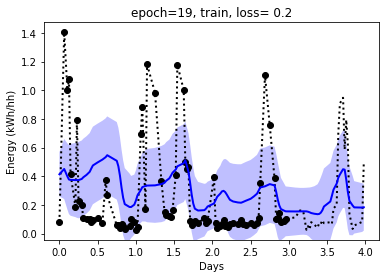

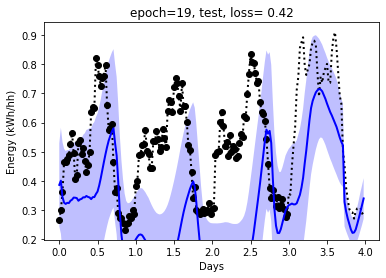

In [52]:
test_loss = plot_from_loader(loader_train, i=vis_i, title=f'epoch={epoch}, train,')
model.eval()
test_loss = plot_from_loader(loader_test, i=vis_i, title=f'epoch={epoch}, test,')

## History

In [53]:
df_hist = pd.DataFrame(history)
df_hist['n'] = df_hist['n']/(df_hist['epoch']+1)
df_hist.head(3)

,epoch,grad_norm,i,kl,loss,n,test_loss,y_std
0,0,12.866674,0,0.0,2.511740,0.0,3.443979,0.112010
1,0,6.965108,100,0.0,1.162269,100.0,1.247307,0.116117
2,0,2.303065,200,0.0,0.499657,200.0,0.030348,0.127476


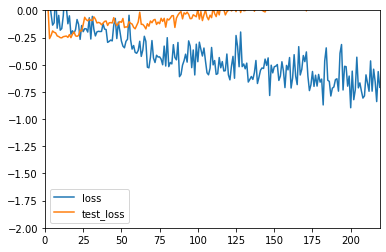

In [54]:
(df_hist[['loss', 'test_loss']]).plot(ylim=[-2,0])

/home/wassname/.pyenv/versions/3.7.2/envs/jup3.7.2/lib/python3.7/site-packages/pandas/plotting/_core.py:441: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(self.ylim)


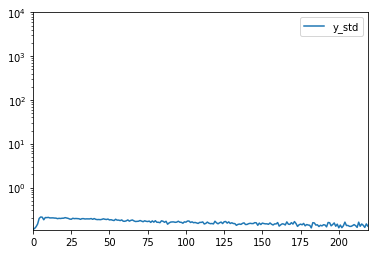

In [55]:
df_hist[['y_std']].plot(ylim=[0,1e4], logy=True)